## Rock Paper Scissors Classifier

### Import Libraries

!pip install opendatasets
!pip install pillow
!pip install pandas
!pip install numpy
!pip install tensorflow
!pip install seaborn
!pip install matplotlib

In [1]:
import opendatasets as od
import os
import re
from PIL import Image

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow import keras
import keras_tuner as kt

from keras.applications.vgg16 import VGG16

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

### Download Dataset

In [2]:
def downloadDataSet():
    url  = "https://www.kaggle.com/datasets/glushko/rock-paper-scissors-dataset/download"
    path = "rock-paper-scissors-dataset"
    
    if os.path.exists(path):
        print("File already downloaded")
    else:
        od.download(url)
        print("File successfully downloaded")

In [3]:
downloadDataSet()

File already downloaded


### Load Dataset

In [4]:
img_height = 150
img_width  = 150
batch_size = 32

def loadDataSet():
    path_train = "rock-paper-scissors-dataset/train"
    path_val   = "rock-paper-scissors-dataset/val"
    path_test  = "rock-paper-scissors-dataset/test"
    return image_dataset_from_directory(path_train, batch_size=batch_size, image_size=(img_height, img_width)), image_dataset_from_directory(path_val, image_size=(img_height, img_width)), image_dataset_from_directory(path_test, image_size=(img_height, img_width))
    

In [5]:
train_DS, val_DS, test_DS = loadDataSet()

Found 1020 files belonging to 3 classes.
Found 804 files belonging to 3 classes.
Found 540 files belonging to 3 classes.


In [6]:
class_names = train_DS.class_names
print(class_names)

['paper', 'rock', 'scissors']


### DataVisualization

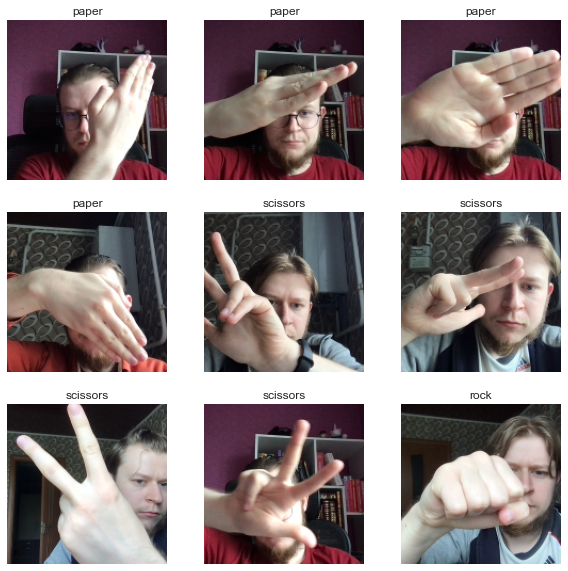

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_DS.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
def plotClassDistribution():
    path = "rock-paper-scissors-dataset"
    class_path = {
        'Rock_train'     : len(os.listdir(os.path.join(path, "train/rock"))),
        'Rock_val'       : len(os.listdir(os.path.join(path, "val/rock"))),
        'Paper_train'    : len(os.listdir(os.path.join(path, "train/paper"))),
        'Paper_val'      : len(os.listdir(os.path.join(path, "val/paper"))),
        'Scissors_train' : len(os.listdir(os.path.join(path, "train/scissors"))),
        'Scissors_val'   : len(os.listdir(os.path.join(path, "val/scissors"))),
    }

    keys = list(class_path.keys())
    values = list(class_path.values())

    ax = sns.barplot(x=keys, y=values)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    plt.tight_layout()
    plt.show()

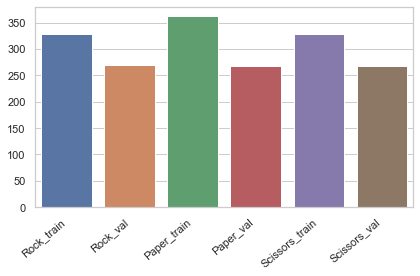

In [9]:
plotClassDistribution()

In [10]:
def plotPieClassDistribution():
    
    
    path = "rock-paper-scissors-dataset"
    class_path = {
        'Rock'     : len(os.listdir(os.path.join(path, "train/rock"))) + len(os.listdir(os.path.join(path, "val/rock"))),
        'Paper'    : len(os.listdir(os.path.join(path, "train/paper"))) + len(os.listdir(os.path.join(path, "val/paper"))),
        'Scissors' : len(os.listdir(os.path.join(path, "train/scissors"))) + len(os.listdir(os.path.join(path, "val/scissors"))),
    }

    keys = list(class_path.keys())
    values = list(class_path.values())
    plt.pie(values,
            explode=(0, 0, 0) , 
            labels=keys,
            autopct='%1.1f%%')
    plt.axis('equal')
    plt.title('Proportion of each observed category')
    plt.show()

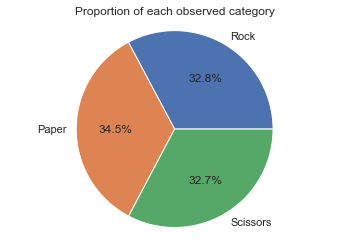

In [11]:
plotPieClassDistribution()

### Modelling

#### Define Model

In [65]:
model_simple = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
])

In [66]:
model_simple.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

In [67]:
model_simple.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 flatten_14 (Flatten)        (None, 41472)             0         
                                                                 
 dense_28 (Dense)            (None, 128)             

#### Train Modell

In [68]:
AUTOTUNE = tf.data.AUTOTUNE

train_DS = train_DS.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_DS = val_DS.cache().prefetch(buffer_size=AUTOTUNE)

In [71]:
keras.backend.clear_session()

In [72]:
history = model_simple.fit(train_DS, validation_data=val_DS, batch_size=batch_size, epochs=50, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='sparse_categorical_accuracy',patience=3)])

Epoch 1/50
32/32 [==============================] - 12s 383ms/step - loss: 0.6759 - sparse_categorical_accuracy: 0.7461 - val_loss: 1.6226 - val_sparse_categorical_accuracy: 0.3905
Epoch 2/50
32/32 [==============================] - 12s 373ms/step - loss: 0.2448 - sparse_categorical_accuracy: 0.9333 - val_loss: 2.2378 - val_sparse_categorical_accuracy: 0.3669
Epoch 3/50
32/32 [==============================] - 12s 376ms/step - loss: 0.0966 - sparse_categorical_accuracy: 0.9824 - val_loss: 3.1755 - val_sparse_categorical_accuracy: 0.3893
Epoch 4/50
32/32 [==============================] - 12s 363ms/step - loss: 0.0335 - sparse_categorical_accuracy: 0.9980 - val_loss: 3.4088 - val_sparse_categorical_accuracy: 0.3483
Epoch 5/50
32/32 [==============================] - 11s 361ms/step - loss: 0.0214 - sparse_categorical_accuracy: 1.0000 - val_loss: 3.8634 - val_sparse_categorical_accuracy: 0.3794
Epoch 6/50
32/32 [==============================] - 11s 352ms/step - loss: 0.0058 - sparse_cate

In [73]:
def model_builder(hp):
    filters_conv1 = hp.Int('filters_conv1', min_value = 16, max_value=64, step=8, default=32)
    filters_conv2 = hp.Int('filters_conv2', min_value = 16, max_value=64, step=8, default=32)
    bias_conv1 = hp.Boolean('bias_conv1', default=True)
    bias_conv2 = hp.Boolean('bias_conv2', default=True)
    bias_dens1 = hp.Boolean('bias_dens1', default=True)
    units_dens1 = hp.Int('units', min_value = 32, max_value = 512, step = 32)
    learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])
    activation_conv1 = hp.Choice('activation_conv1', values = ['softmax', 'elu', 'tanh','sigmoid', 'linear'])
    activation_conv2 = hp.Choice('activation_conv2', values = ['softmax', 'elu', 'tanh','sigmoid', 'linear'])
    activation_dens1 = hp.Choice('activation_dens1', values = ['softmax', 'elu', 'tanh','sigmoid', 'linear'])

    model_tune = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters_conv1, 
                               (3, 3), 
                               activation = activation_conv1, 
                               use_bias = bias_conv1,
                               input_shape = (150, 150, 3)), 
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(filters_conv2, 
                               (3, 3), 
                               use_bias = bias_conv2,
                               activation = activation_conv2),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units_dens1, 
                              use_bias = bias_dens1,
                              activation=activation_dens1),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    model_tune.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate), 
                       loss = 'sparse_categorical_crossentropy', 
                       metrics=['sparse_categorical_accuracy'])
    return model_tune


In [19]:
%load_ext tensorboard

In [20]:
%tensorboard --logdir hb/tb_logs --port 6006

Reusing TensorBoard on port 6006 (pid 16528), started 9:39:53 ago. (Use '!kill 16528' to kill it.)

In [21]:

tuner_hb = kt.Hyperband(
    model_builder,
    objective='val_sparse_categorical_accuracy',
    max_epochs=10,
    hyperband_iterations=2, 
    overwrite=True,
    seed=42,
    directory='hb/tb')

In [22]:

tuner_hb.search(train_DS,
             validation_data=val_DS,
             epochs=10,
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy',patience=3), tf.keras.callbacks.TensorBoard("hb/tb_logs")])

Trial 180 Complete [00h 00m 38s]
val_accuracy: 0.3333333432674408

Best val_accuracy So Far: 0.5310945510864258
Total elapsed time: 02h 45m 16s
INFO:tensorflow:Oracle triggered exit


In [23]:
%tensorboard --logdir rs/tb_logs --port 6007

Reusing TensorBoard on port 6007 (pid 4292), started 10:13:56 ago. (Use '!kill 4292' to kill it.)

In [24]:
tuner_rs = kt.RandomSearch(
    model_builder, 
    objective = 'val_sparse_categorical_accuracy', 
    max_trials = 50, 
    overwrite=True,
    seed=42,
    directory='rs/tb') 

In [25]:

tuner_rs.search(train_DS,
             validation_data=val_DS,
             epochs=50,
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy',patience=3), tf.keras.callbacks.TensorBoard("rs/tb_logs")])

Trial 50 Complete [00h 00m 38s]
val_accuracy: 0.35696518421173096

Best val_accuracy So Far: 0.5398010015487671
Total elapsed time: 01h 05m 39s
INFO:tensorflow:Oracle triggered exit


In [26]:
%tensorboard --logdir bo/tb_logs --port 6008

Reusing TensorBoard on port 6008 (pid 13884), started 10:40:15 ago. (Use '!kill 13884' to kill it.)

In [74]:
tuner_bo = kt.BayesianOptimization(
    model_builder, 
    objective = 'val_sparse_categorical_accuracy', 
    max_trials = 10, 
    overwrite=True, 
    seed=42,
    directory="bo/tb") 

In [ ]:

tuner_bo.search(train_DS,
             validation_data=val_DS,
             epochs=10,
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy',patience=3), tf.keras.callbacks.TensorBoard("bo/tb_logs")])

Trial 3 Complete [00h 03m 55s]
val_sparse_categorical_accuracy: 0.3868159055709839

Best val_sparse_categorical_accuracy So Far: 0.42786070704460144
Total elapsed time: 00h 09m 18s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
64                |64                |filters_conv1
64                |48                |filters_conv2
True              |True              |bias_conv1
True              |True              |bias_conv2
False             |True              |bias_dens1
32                |64                |units
0.0001            |0.0001            |learning_rate
softmax           |elu               |activation_conv1
linear            |tanh              |activation_conv2
linear            |sigmoid           |activation_dens1

Epoch 1/10
32/32 [==============================] - 30s 925ms/step - loss: 1.1907 - sparse_categorical_accuracy: 0.4618 - val_loss: 1.1791 - val_sparse_categorical_accuracy: 0.2910
Epoch 2/10
32/32 [===========================

In [29]:
import os
import json

vis_data = []
rootdir = 'bo/tb/untitled_project'
for subdirs, dirs, files in os.walk(rootdir):
    for file in files:
        if file.endswith("trial.json"):
            with open(subdirs + '/' + file, 'r') as json_file:
                data = json_file.read()
            vis_data.append(json.loads(data))

In [30]:
import hiplot as hip
#num_of_epochs as variable
#Quelle: https://medium.com/roonyx/neural-network-hyper-parameter-tuning-with-keras-tuner-and-hiplot-7637677821fa
data = [{'filters_conv1': vis_data[idx]['hyperparameters']['values']['filters_conv1'],
         'filters_conv2': vis_data[idx]['hyperparameters']['values']['filters_conv2'], 
         'bias_conv1': vis_data[idx]['hyperparameters']['values']['bias_conv1'], 
         'bias_conv2': vis_data[idx]['hyperparameters']['values']['bias_conv2'], 
         'bias_dens1': vis_data[idx]['hyperparameters']['values']['bias_dens1'], 
         'units': vis_data[idx]['hyperparameters']['values']['units'], 
         'learning_rate': vis_data[idx]['hyperparameters']['values']['learning_rate'], 
         'activation_conv1': vis_data[idx]['hyperparameters']['values']['activation_conv1'], 
         'activation_conv2': vis_data[idx]['hyperparameters']['values']['activation_dens1'], 
         'activation_dens1': vis_data[idx]['hyperparameters']['values']['activation_dens1'],
         'loss': vis_data[idx]['metrics']['metrics']['loss']['observations'][0]['value'],  
         'val_loss': vis_data[idx]['metrics']['metrics']['val_loss']['observations'][0]['value'], 
         'accuracy': vis_data[idx]['metrics']['metrics']['accuracy']['observations'][0]['value'],
         'val_accuracy': vis_data[idx]['metrics']['metrics']['val_accuracy']['observations'][0]['value']} for idx in range(50)]

hip.Experiment.from_iterable(data).display()

<IPython.core.display.Javascript object>

In [31]:
#best_model = tuner_bo.get_best_models(1)[0]

In [32]:
#best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

In [33]:
#tuner_bo.search_space_summary()

In [34]:
#tuner_bo.results_summary()

In [35]:
tuner_hb.results_summary(1)

Results summary
Results in hb/tb\untitled_project
Showing 1 best trials
Trial summary
Hyperparameters:
filters_conv1: 24
filters_conv2: 16
bias_conv1: True
bias_conv2: False
bias_dens1: False
units: 256
learning_rate: 0.001
activation_conv1: sigmoid
activation_conv2: tanh
activation_dens1: linear
tuner/epochs: 6
tuner/initial_epoch: 2
tuner/bracket: 3
tuner/round: 1
tuner/trial_id: 0119
Score: 0.5310945510864258


In [36]:
tuner_rs.results_summary(1)

Results summary
Results in rs/tb\untitled_project
Showing 1 best trials
Trial summary
Hyperparameters:
filters_conv1: 24
filters_conv2: 24
bias_conv1: False
bias_conv2: False
bias_dens1: True
units: 192
learning_rate: 0.001
activation_conv1: tanh
activation_conv2: elu
activation_dens1: elu
Score: 0.5398010015487671


In [37]:
tuner_bo.results_summary(1)

Results summary
Results in bo/tb\untitled_project
Showing 1 best trials
Trial summary
Hyperparameters:
filters_conv1: 64
filters_conv2: 16
bias_conv1: False
bias_conv2: True
bias_dens1: False
units: 32
learning_rate: 0.0001
activation_conv1: softmax
activation_conv2: linear
activation_dens1: softmax
Score: 0.5534825921058655


In [40]:
model_simple_hb = tf.keras.Sequential([
        tf.keras.layers.Conv2D(24, 
                               (3, 3), 
                               activation = 'sigmoid', 
                               use_bias = True,
                               input_shape = (150, 150, 3)), 
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(16, 
                               (3, 3), 
                               use_bias = False,
                               activation = 'tanh'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, 
                              use_bias = False,
                              activation='linear'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
model_simple_hb.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
                       loss = 'sparse_categorical_crossentropy', 
                       metrics=['accuracy'])
history_hb = model_simple_hb.fit(train_DS, validation_data=val_DS, batch_size=batch_size, epochs=50, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3)])

Epoch 1/50
32/32 [==============================] - 8s 240ms/step - loss: 8.4187 - accuracy: 0.4902 - val_loss: 3.6247 - val_accuracy: 0.4192
Epoch 2/50
32/32 [==============================] - 8s 238ms/step - loss: 0.7273 - accuracy: 0.8294 - val_loss: 2.8595 - val_accuracy: 0.4316
Epoch 3/50
32/32 [==============================] - 7s 229ms/step - loss: 0.2182 - accuracy: 0.9206 - val_loss: 2.6865 - val_accuracy: 0.4328
Epoch 4/50
32/32 [==============================] - 8s 244ms/step - loss: 0.0466 - accuracy: 0.9824 - val_loss: 2.5903 - val_accuracy: 0.4764
Epoch 5/50
32/32 [==============================] - 8s 239ms/step - loss: 0.0172 - accuracy: 0.9971 - val_loss: 2.5246 - val_accuracy: 0.4776
Epoch 6/50
32/32 [==============================] - 8s 244ms/step - loss: 0.0070 - accuracy: 1.0000 - val_loss: 2.5568 - val_accuracy: 0.4888
Epoch 7/50
32/32 [==============================] - 8s 251ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 2.5467 - val_accuracy: 0.4838
Epoch 

In [41]:
model_simple_rs = tf.keras.Sequential([
        tf.keras.layers.Conv2D(24, 
                               (3, 3), 
                               activation = 'tanh', 
                               use_bias = False,
                               input_shape = (150, 150, 3)), 
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(24, 
                               (3, 3), 
                               use_bias = False,
                               activation = 'elu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(192, 
                              use_bias = True,
                              activation='elu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
model_simple_rs.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
                       loss = 'sparse_categorical_crossentropy', 
                       metrics=['accuracy'])
history_rs = model_simple_rs.fit(train_DS, validation_data=val_DS, batch_size=batch_size, epochs=50, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3)])

Epoch 1/50
32/32 [==============================] - 8s 236ms/step - loss: 13.0361 - accuracy: 0.4127 - val_loss: 1.2382 - val_accuracy: 0.3483
Epoch 2/50
32/32 [==============================] - 8s 236ms/step - loss: 0.8297 - accuracy: 0.5765 - val_loss: 1.1462 - val_accuracy: 0.4266
Epoch 3/50
32/32 [==============================] - 7s 229ms/step - loss: 0.6722 - accuracy: 0.7186 - val_loss: 1.2178 - val_accuracy: 0.3993
Epoch 4/50
32/32 [==============================] - 8s 244ms/step - loss: 0.5497 - accuracy: 0.8108 - val_loss: 1.4296 - val_accuracy: 0.3731
Epoch 5/50
32/32 [==============================] - 8s 250ms/step - loss: 0.5038 - accuracy: 0.8118 - val_loss: 1.2671 - val_accuracy: 0.3769


In [60]:
model_simple_bo = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, 
                               (3, 3), 
                               activation = 'softmax', 
                               use_bias = False,
                               input_shape = (150, 150, 3)), 
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(16, 
                               (3, 3), 
                               use_bias = True,
                               activation = 'linear'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, 
                              use_bias = False,
                              activation='softmax'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
model_simple_bo.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), 
                       loss = 'sparse_categorical_crossentropy', 
                       metrics=['sparse_categorical_accuracy'])
history_bo = model_simple_bo.fit(train_DS, validation_data=val_DS, batch_size=batch_size, epochs=50, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3)])

Epoch 1/50
32/32 [==============================] - 27s 847ms/step - loss: 1.0911 - accuracy: 0.3804 - val_loss: 1.0920 - val_accuracy: 0.4303
Epoch 2/50
32/32 [==============================] - 26s 833ms/step - loss: 1.0580 - accuracy: 0.5422 - val_loss: 1.0939 - val_accuracy: 0.3346
Epoch 3/50
32/32 [==============================] - 26s 805ms/step - loss: 1.0097 - accuracy: 0.6314 - val_loss: 1.0848 - val_accuracy: 0.4291
Epoch 4/50
32/32 [==============================] - 27s 830ms/step - loss: 0.9619 - accuracy: 0.7176 - val_loss: 1.0791 - val_accuracy: 0.4378
Epoch 5/50
32/32 [==============================] - 25s 801ms/step - loss: 0.9234 - accuracy: 0.7657 - val_loss: 1.0796 - val_accuracy: 0.4328
Epoch 6/50
32/32 [==============================] - 26s 804ms/step - loss: 0.8931 - accuracy: 0.7990 - val_loss: 1.0745 - val_accuracy: 0.4366
Epoch 7/50
32/32 [==============================] - 27s 843ms/step - loss: 0.8677 - accuracy: 0.8343 - val_loss: 1.0737 - val_accuracy: 0.4403

In [48]:
def plot_evaluation(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [61]:
results_simple = model_simple.evaluate(test_DS)

17/17 [==============================] - 1s 76ms/step - loss: 7.9867 - accuracy: 0.3630


In [62]:
results_hb = model_simple_hb.evaluate(test_DS)

17/17 [==============================] - 1s 65ms/step - loss: 2.8666 - accuracy: 0.3352


In [63]:
results_rs = model_simple_rs.evaluate(test_DS)

17/17 [==============================] - 1s 63ms/step - loss: 1.2349 - accuracy: 0.3889


In [64]:
results_bo = model_simple_bo.evaluate(test_DS)

17/17 [==============================] - 3s 175ms/step - loss: 1.1060 - accuracy: 0.3556


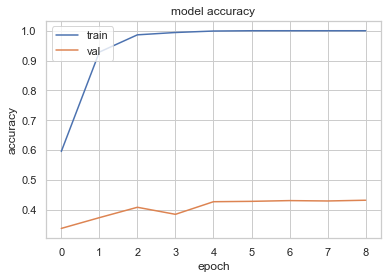

In [49]:
plot_evaluation(history)